<a href="https://colab.research.google.com/github/LeoVogiatzis/medical_data_analysis/blob/main/Thyroid_Sick_Cost_Sensitive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+git://github.com/albahnsen/CostSensitiveClassification.git

  Cloning git://github.com/albahnsen/CostSensitiveClassification.git to /tmp/pip-req-build-5a6nma86
  Running command git clone -q git://github.com/albahnsen/CostSensitiveClassification.git /tmp/pip-req-build-5a6nma86
  Created wheel for costcla: filename=costcla-0.6-cp37-none-any.whl size=3981319 sha256=55ebc8e2bfeaa2e07e3c3329e2055a9fba3b89f4fe8ad962a416e1432fdbf4f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-4gwyag29/wheels/88/50/a9/46090896420899de912f048c5d91b30b25d5e32d88a2fc23c6
  Created wheel for pyea: filename=pyea-0.2-cp37-none-any.whl size=6017 sha256=5b5a2e5bff43ef3f9493d97d4d516fc06c0eba235e0cc87d2e268f7ccbead4d7
  Stored in directory: /root/.cache/pip/wheels/3c/bf/6e/06f8b0ed23cbc1fe956f8b6756535cb36f0b68c2f0f2342178
Successfully built costcla pyea


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from costcla.metrics import cost_loss
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn import model_selection, metrics

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functio

In [3]:
data = pd.read_csv("Thyroid_Sick_fixed.csv")

In [4]:
print(data.shape)
data.head()


(3772, 30)


,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,Class
0,41.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.30,t,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.10,t,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on thyroxine               3772 non-null   object 
 3   query on thyroxine         3772 non-null   object 
 4   on antithyroid medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid surgery            3772 non-null   object 
 8   I131 treatment             3772 non-null   object 
 9   query hypothyroid          3772 non-null   object 
 10  query hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [6]:
data.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000,0.0
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649,NaN
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698,NaN
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000,NaN
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000,NaN
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000,NaN
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000,NaN
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


In [7]:
data['Class'].value_counts()

negative    3541
sick         231
Name: Class, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


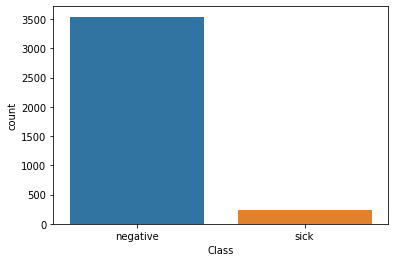

In [8]:
sns.countplot(data['Class'])

In [9]:
print(data.isnull().sum())

age                             1
sex                           150
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           369
T3 measured                     0
T3                            769
TT4 measured                    0
TT4                           231
T4U measured                    0
T4U                           387
FTI measured                    0
FTI                           385
TBG measured                    0
TBG                          3772
referral source                 0
Class         

In [10]:
data.drop(["TBG", "referral source"], axis=1, inplace=True)
data = data.loc[:, ~data.columns.str.endswith("measured")]

In [11]:
data.dropna(subset=['sex'], inplace=True)

data = data.replace(["f", "t"], [0, 1])
data = data.replace(["F", "M"], [0, 1])
data = data.replace(["negative", "sick"], [0, 1])

#Class = {'N': 1,'female': 0}



In [12]:
print(data.shape)
data


(3622, 22)


,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class
0,41.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.30,2.5,125.0,1.14,109.0,0
1,23.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.10,2.0,102.0,NaN,NaN,0
2,46.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.98,NaN,109.0,0.91,120.0,0
3,70.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,1.9,175.0,NaN,NaN,0
4,70.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.72,1.2,61.0,0.87,70.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,0
3768,68.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,2.1,124.0,1.08,114.0,0
3769,74.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.10,1.8,112.0,1.07,105.0,0
3770,72.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.70,2.0,82.0,0.94,87.0,0


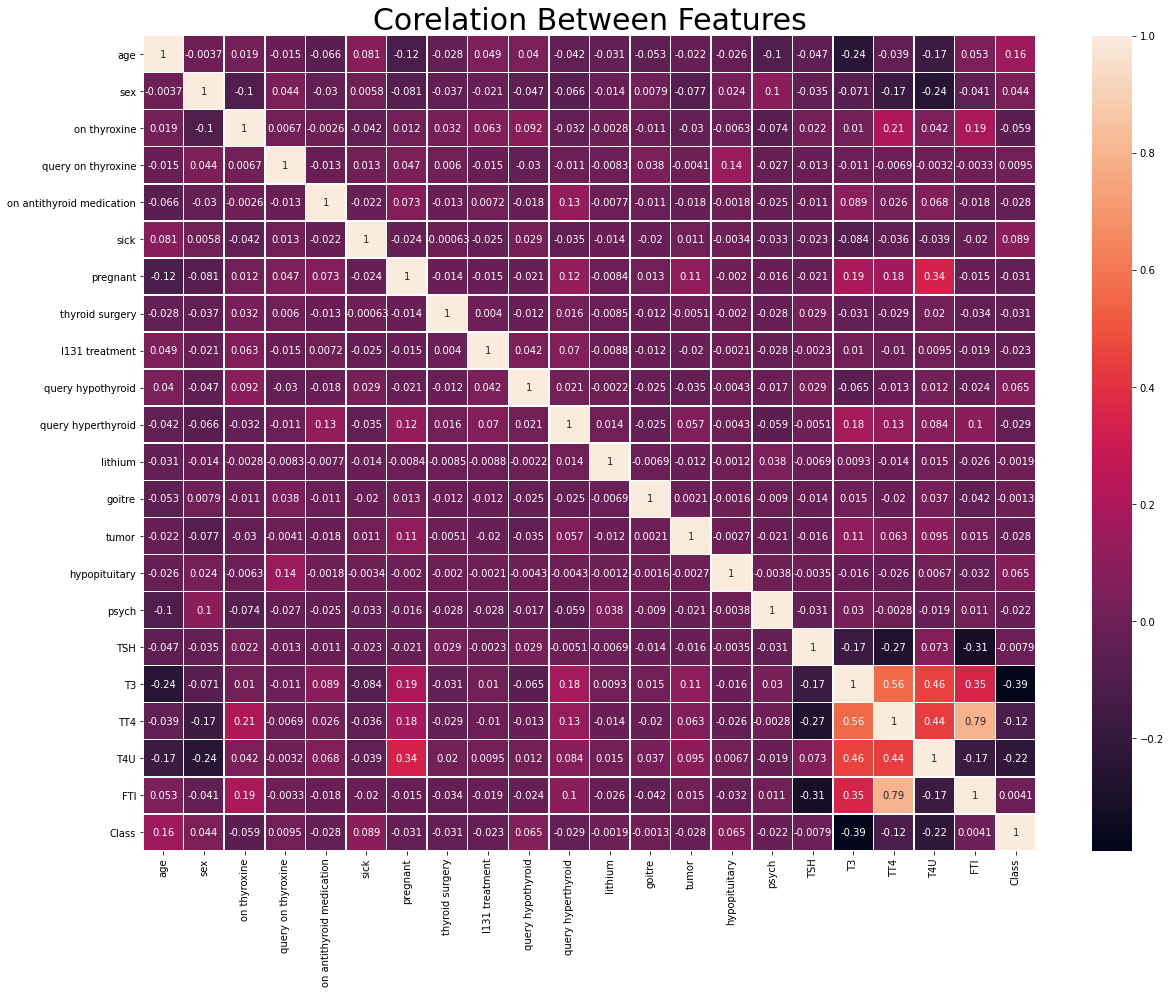

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 15) 
sns.heatmap(data.corr(), annot = True, linewidths=.5)
plt.title('Corelation Between Features', fontsize = 30)
plt.show()

In [14]:
X = data.drop(columns=['Class'])
y = data['Class']

In [15]:
X.head()


,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI
0,41.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.30,2.5,125.0,1.14,109.0
1,23.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.10,2.0,102.0,NaN,NaN
2,46.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.98,NaN,109.0,0.91,120.0
3,70.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,1.9,175.0,NaN,NaN
4,70.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.72,1.2,61.0,0.87,70.0


In [16]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

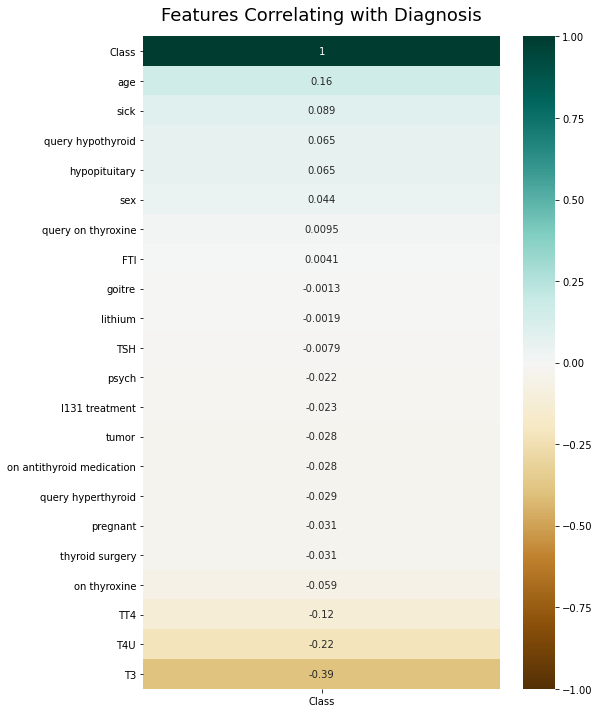

In [19]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data.corr()[['Class']].sort_values(by='Class', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Diagnosis', fontdict={'fontsize':18}, pad=16);

In [20]:
pca = PCA(n_components=10)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [21]:
#0 is negative, 1 is sick
fp = np.full((y_test.shape[0],1), 1)
fn = np.full((y_test.shape[0],1), 4)
tp = np.zeros((y_test.shape[0],1))
tn = np.zeros((y_test.shape[0],1))
cost_matrix = np.hstack((fp, fn, tp, tn))

target_names = ['negative', 'sick']


without sampling
Counter({0: 2379, 1: 156})
              precision    recall  f1-score   support

    negative       0.97      0.99      0.98      1018
        sick       0.79      0.49      0.61        69

    accuracy                           0.96      1087
   macro avg       0.88      0.74      0.79      1087
weighted avg       0.96      0.96      0.96      1087

Loss 149

[[1009   35]
 [   9   34]]


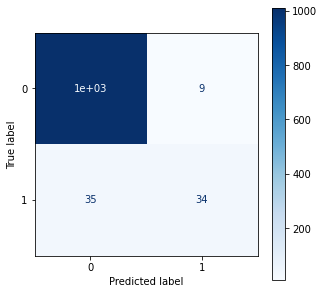

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
print("without sampling")
print(Counter(y_train))
clf = RandomForestClassifier(n_estimators=10, random_state=0)
#clf = SVC(kernel='linear', probability=False, C=1)
#clf = DecisionTreeClassifier()
#clf = LogisticRegression()
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred, target_names=target_names))
loss = cost_loss(y_test, y_pred, cost_matrix)
print("Loss %d\n" %loss)
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides


from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(5, 5))
target = list(set(data['Class'].to_list()))
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax)


with undersampling
Counter({0: 156, 1: 156})
              precision    recall  f1-score   support

    negative       0.98      0.85      0.91      1018
        sick       0.26      0.78      0.39        69

    accuracy                           0.84      1087
   macro avg       0.62      0.81      0.65      1087
weighted avg       0.94      0.84      0.88      1087

[[861  15]
 [157  54]]
Loss:217



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


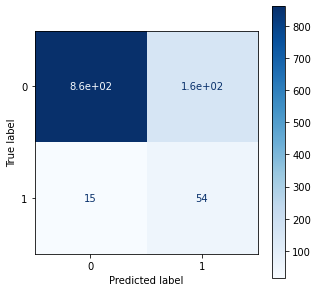

In [23]:
print("with undersampling")
sampler = RandomUnderSampler(sampling_strategy={0: 156, 1: 156}, random_state=1)
X_rs, y_rs = sampler.fit_resample(x_train, y_train)
print(Counter(y_rs))

model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("Loss:%d\n" %loss)

target = list(set(data['Class'].to_list()))
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax)


with oversampling
Counter({0: 2379, 1: 2379})
              precision    recall  f1-score   support

    negative       0.97      0.99      0.98      1018
        sick       0.76      0.49      0.60        69

    accuracy                           0.96      1087
   macro avg       0.86      0.74      0.79      1087
weighted avg       0.95      0.96      0.95      1087

[[1007   35]
 [  11   34]]
Loss : 151



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


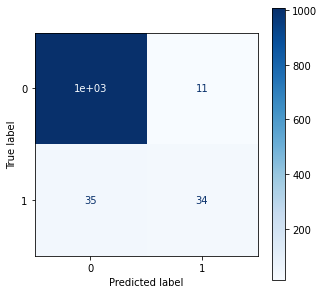

In [24]:
print("with oversampling")
sampler = RandomOverSampler(sampling_strategy={0:2379 , 1: 2379}, random_state=1)
X_rs, y_rs = sampler.fit_resample(x_train, y_train)
print(Counter(y_rs))

model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("Loss : %d\n" %loss)

target = list(set(data['Class'].to_list()))
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax)


with combination
Counter({0: 1500, 1: 1500})
              precision    recall  f1-score   support

    negative       0.97      0.98      0.98      1018
        sick       0.71      0.58      0.64        69

    accuracy                           0.96      1087
   macro avg       0.84      0.78      0.81      1087
weighted avg       0.96      0.96      0.96      1087

[[1002   29]
 [  16   40]]
Loss :132



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


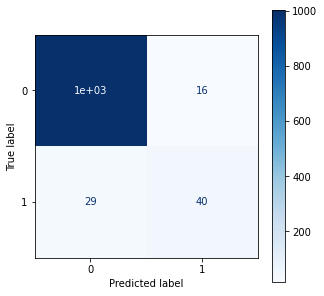

In [25]:
print("with combination")
sampler = RandomUnderSampler(sampling_strategy={0: 1500, 1: 156}, random_state=1)
X_rs, y_rs = sampler.fit_resample(x_train, y_train)
sampler = RandomOverSampler(sampling_strategy={0: 1500, 1: 1500}, random_state=1)
X_rs, y_rs = sampler.fit_resample(X_rs, y_rs)
print(Counter(y_rs))

model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("Loss :%d\n" %loss)

target = list(set(data['Class'].to_list()))
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax)
